In [1]:
from numpy import linalg as la

class FuzzyART(object):
    def __init__(self, rho, alpha, beta, max_iter):
        self.rho = rho
        self.alpha = alpha
        self.beta = beta
        self.max_iter = max_iter

    def run(self, data):
        # initialize variables
        num_clusters = 1
        num_samples, feature_dim = data.shape
        input_dim = feature_dim
        w = data[0]
        w = np.expand_dims(w, axis=0)
        a = float(self.alpha)
        a = np.expand_dims(a, axis=0)
        
        w_old = None

        y_pred = np.zeros(num_samples)
        iterations = 1

        # repeat the learning until either convergence or max_iter
        while iterations <= self.max_iter:
            w_old = w
            print(iterations)

            for ix in range(num_samples):
                # calculate the category choice values
                T = np.zeros(num_clusters)
                for jx in range(num_clusters):
                    T[jx] = np.power((1 + np.power(la.norm(data[ix] - w[jx], 2), 2) / a[jx]), (-(a[jx] + 1)/2))
                                                   
                M = T 

                # pick the winning category
                vigilance_test = self.rho
                match_attempts = 0
                mismatch_flag = True

                for kx in range(len(T)):
                    # winner-take-all selection
                    jx = np.argmax(T)
                    # vigilance test
                    if M[jx] >= vigilance_test:
                        #print('PASS')

                        y_pred[ix] = jx
                                                
                        w_temp = w[jx]
                        
                        A = (a[jx] + 1) / a[jx]
                        B = (1 + ((la.norm(data[ix] - w[jx], 2)) ** 2 / a[jx])) ** (-(a[jx]+3)/2)
                        C = (data[ix] - w[jx])
                        w[jx] = w[jx] + self.beta*A*B*C
                        
                        if a[jx]<=0.1:
                            a[jx] = 0.1  
                        
                        D = (la.norm(data[ix] - w_temp, 2)) ** 2
                        G = D/a[jx] + 1
                        E = D*(a[jx]+1)/((2*(a[jx] ** 2)*G))
                        F = 0.5*np.log(G)
                        a[jx] = a[jx] + self.beta*T[jx]*(E-F)
                        
                                         
                        if a[jx]<=0.1:
                            a[jx] = 0.1                        
                        
                        mismatch_flag = False
                        #print(a[jx]<=0.1)
                        #print(a[0]) 
                        #print(type(a[0]))
                        break

                # check if the uncommitted node was the winner
                if mismatch_flag:
                    num_clusters += 1
                    w = np.concatenate((w, np.expand_dims(data[ix], axis=0)))
                    a = np.concatenate((a, np.expand_dims(float(self.alpha), axis=0)))
            iterations += 1

        # return results
        self.iterations = iterations
        self.w = w
        self.num_clusters = num_clusters

        return y_pred, w, a

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
[[-2.88152094  2.57955775]
 [-0.06640111  0.69234345]
 [-3.35967328  0.9821389 ]
 [ 1.25705096 -0.82227675]
 [-3.16238319  3.34430577]]
[8.22113059 6.73531756 7.85451102 5.56204104 6.70123397]


C:\Users\hustw\Anaconda3\lib\site-packages\ipykernel_launcher.py:29: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.


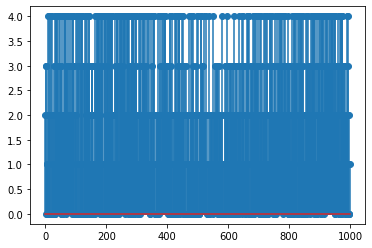

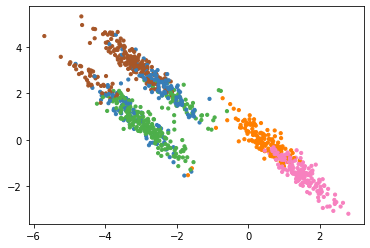

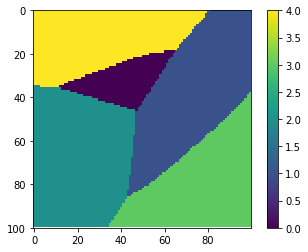

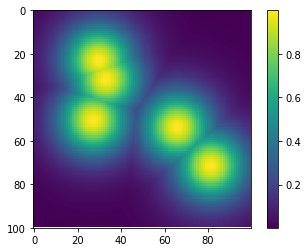

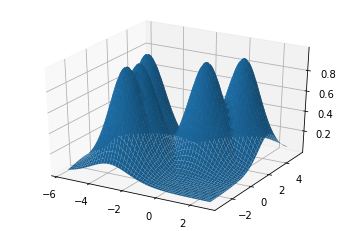

In [2]:
%matplotlib inline
import numpy as np
from sklearn import datasets
from itertools import cycle, islice
from matplotlib import cm
from mpl_toolkits.mplot3d import axes3d
import matplotlib.pyplot as plt

#blobs = datasets.make_blobs(n_samples=1000, n_features=2, centers=5, random_state=1)
#blobs = datasets.make_circles(n_samples=1000, factor=.5, noise=.05)
#blobs = datasets.make_blobs(n_samples=1000,cluster_std=[1.0, 2.5, 0.5],random_state=1)
#Anisotropicly distributed data
X, y = datasets.make_blobs(n_samples=1000, random_state=170)
transformation = [[0.6, -0.6], [-0.4, 0.8]]
X_aniso = np.dot(X, transformation)
blobs = (X_aniso, y)


#art = FuzzyART(rho=0.04, alpha=1, beta=0.1, max_iter=10)
#art = FuzzyART(rho=.001, alpha=1, beta=0.5, max_iter=30)
art = FuzzyART(rho=.02, alpha=1, beta=0.5, max_iter=30)
y_pred, w, a = art.run(blobs[0])
print(w)
print(a)
colors = np.array(list(islice(cycle(['#377eb8', '#ff7f00', '#4daf4a',
                                             '#f781bf', '#a65628', '#984ea3',
                                             '#999999', '#e41a1c', '#dede00']),
                                      int(max(y_pred) + 1))))
plt.stem(y_pred)
plt.show()



y_label = [int(y) for y in y_pred]
plt.scatter(blobs[0][:, 0], blobs[0][:, 1], s=10, color=colors[y_label])
plt.show()

x_min = np.amin(blobs[0][:, 0])
x_max = np.amax(blobs[0][:, 0])
y_min = np.amin(blobs[0][:, 1])
y_max = np.amax(blobs[0][:, 1])

x = np.linspace(x_min, x_max, 100)
y = np.linspace(y_min, y_max, 100)
len_x = len(x)
len_y = len(y)
len_w = len(w)
T = np.zeros(len_w)
boundary = np.zeros([len_x,len_y])
boundary2 = np.zeros([len_x,len_y])
X, Y = np.meshgrid(x, y)
for ix in range(len_x):
    for jx in range(len_y):
        for kx in range(len_w):
            T[kx] = np.power((1 + np.power(la.norm([x[ix], y[jx]] - w[kx], 2), 2) / a[kx]), (-(a[kx] + 1)/2)) 
        #T0 = np.power((1 + np.power(la.norm([x[ix], y[jx]] - w[0], 2), 2) / art.alpha), (-(art.alpha + 1)/2))
        #T1 = np.power((1 + np.power(la.norm([x[ix], y[jx]] - w[1], 2), 2) / art.alpha), (-(art.alpha + 1)/2))
       # T2 = np.power((1 + np.power(la.norm([x[ix], y[jx]] - w[2], 2), 2) / art.alpha), (-(art.alpha + 1)/2))
        boundary[99-jx,ix] = np.argmax(T)
        boundary2[99-jx,ix] = np.amax(T)
        
plt.imshow(boundary)
plt.colorbar()
plt.ylim(100, 0) 
plt.show()        

plt.imshow(boundary2)
plt.colorbar()
plt.ylim(100, 0) 
plt.show()  


fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X, Y, boundary2)
plt.show()  